In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.head()

,id,Date,Count,Hour,Hotness,Humidity,Wind Speed,Visibility,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Working Day
0,1,05/08/2018,222,6:00,300.3,83,5.04,1080,0.00,0.0,0.0,Summer,NO,YES
1,2,21/01/2018,170,23:00,272.6,32,2.16,2000,0.00,0.0,0.0,Winter,NO,YES
2,3,11/05/2018,486,6:00,285.0,83,1.44,321,0.01,0.0,0.0,Spring,NO,YES
3,4,05/07/2018,929,13:00,301.1,67,3.96,1772,1.43,0.0,0.0,Summer,NO,YES
4,5,02/01/2018,58,5:00,269.9,67,2.16,1384,0.00,0.0,0.0,Winter,NO,YES


In [ ]:
df.describe()

,id,Count,Hotness,Humidity,Wind Speed,Visibility,Solar Radiation,Rainfall,Snowfall
count,4986.000000,4986.000000,4986.000000,4986.000000,4986.000000,4986.000000,4986.000000,4986.000000,4986.00000
mean,2493.500000,705.851986,285.977778,58.247493,6.159495,1432.546731,0.576897,0.154673,0.06775
std,1439.478551,646.444092,11.838222,20.373339,3.679312,605.976182,0.874589,1.121118,0.40789
min,1.000000,0.000000,255.200000,0.000000,0.000000,33.000000,0.000000,0.000000,0.00000
25%,1247.250000,191.000000,276.700000,43.000000,3.240000,942.250000,0.000000,0.000000,0.00000
50%,2493.500000,505.000000,286.700000,57.000000,5.400000,1678.000000,0.010000,0.000000,0.00000
75%,3739.750000,1066.750000,295.400000,74.000000,8.280000,1999.000000,0.950000,0.000000,0.00000
max,4986.000000,3556.000000,312.400000,98.000000,26.280000,2000.000000,3.520000,29.500000,8.80000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4986 non-null   int64  
 1   Date             4986 non-null   object 
 2   Count            4986 non-null   int64  
 3   Hour             4986 non-null   object 
 4   Hotness          4986 non-null   float64
 5   Humidity         4986 non-null   int64  
 6   Wind Speed       4986 non-null   float64
 7   Visibility       4986 non-null   int64  
 8   Solar Radiation  4986 non-null   float64
 9   Rainfall         4986 non-null   float64
 10  Snowfall         4986 non-null   float64
 11  Seasons          4986 non-null   object 
 12  Holiday          4986 non-null   object 
 13  Working Day      4986 non-null   object 
dtypes: float64(5), int64(4), object(5)
memory usage: 545.5+ KB


In [ ]:
df.isnull().sum()

id                 0
Date               0
Count              0
Hour               0
Hotness            0
Humidity           0
Wind Speed         0
Visibility         0
Solar Radiation    0
Rainfall           0
Snowfall           0
Seasons            0
Holiday            0
Working Day        0
dtype: int64

[Text(0.5, 1.0, 'Theoritical quantiles')]

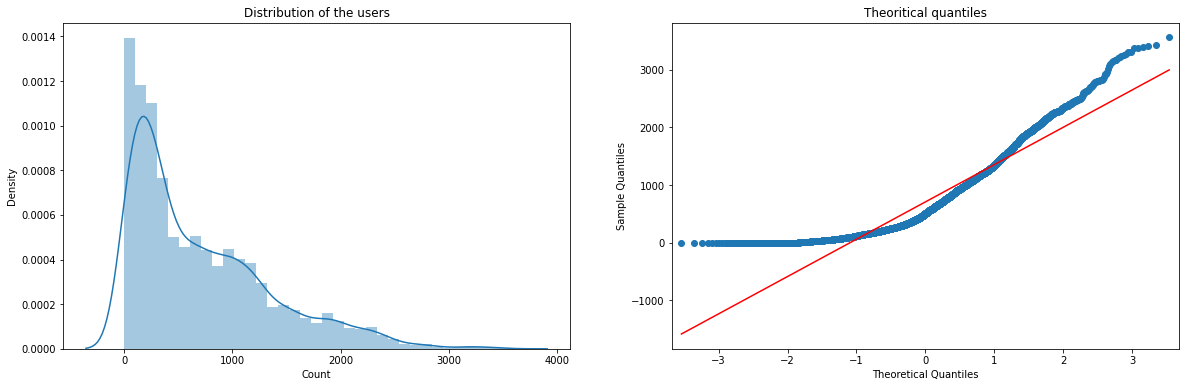

In [ ]:
from statsmodels.graphics.gofplots import qqplot
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.distplot(df['Count'], ax=ax1)
ax1.set(title='Distribution of the users')
qqplot(df['Count'], ax=ax2, line='s')
ax2.set(title='Theoritical quantiles')



<AxesSubplot:>

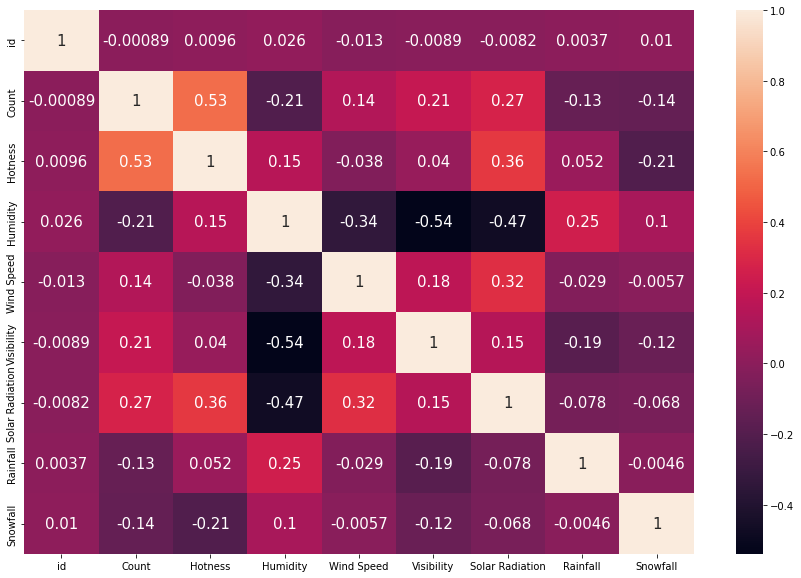

In [ ]:
corr = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, annot_kws={'size':15})

In [ ]:
def one_hot_encoding(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data


def prep(df):
    df = df.drop(['id'], axis=1)
    df['Date'] = df['Date'].apply(lambda x:datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d"))
    df['Date'] = pd.to_datetime(df['Date'])
    df['Hour'] = df['Hour'].apply(lambda x: x.split(':', 1)[0])
    df['Hour']=df['Hour'].astype(int)
    df['year'] = pd.to_datetime(df['Date']).dt.year
    df['month'] = pd.to_datetime(df['Date']).dt.month
    df['day'] = df['Date'].apply(lambda x : x.dayofweek)
    df['Seasons']= df['Seasons'].map({"Winter":1,"Summer":2,"Spring":3,"Autumn":4})
    df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x=="YES" else 0)
    df['Working Day'] = df['Working Day'].apply(lambda x: 1 if x=="YES" else 0)
    # cols = [
    #         # 'Seasons','month','Hour',
    #         'Holiday','day','Working Day'
    #         ]
    # df_oh = df
    # for col in cols:
    #     df_oh = one_hot_encoding(df_oh, col)
    X = df.drop(columns=['Date'], axis=1)
    return X

In [ ]:
y = df['Count']
x = prep(df)
x = x.drop(['Count'] , axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

168.5587456555546

In [ ]:
# from sklearn.ensemble import BaggingRegressor
# from sklearn.tree import ExtraTreeRegressor
# extra_tree = ExtraTreeRegressor(random_state=0)
# reg = BaggingRegressor(extra_tree, random_state=0).fit(x_train, y_train)
# reg.score(x_test, y_test)
# y_pred = reg.predict(x_test)
# np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
mdl = RandomForestRegressor()
mdl.fit(x_train , y_train)
mdl.score(x_test , y_test)

0.9318947859359684

In [ ]:
y_pred = mdl.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))

167.55978460876665

In [ ]:
# from sklearn.model_selection import GridSearchCV

# regr = RandomForestRegressor()

# parameters = {'n_estimators':[200] , 'min_samples_split':[2]}
# clf = GridSearchCV(regr , parameters)

In [ ]:
# clf.fit(x_train , y_train)

In [ ]:
# clf.best_score_

In [ ]:
regr = RandomForestRegressor(n_estimators=200, max_depth=50, min_samples_split=2)
regr.fit(x_train , y_train)
regr.score(x_test , y_test)

0.9320102444191134

In [ ]:
y_pred = regr.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))

167.41769266196903

In [ ]:
# from sklearn.model_selection import cross_val_score, cross_val_predict
# score=cross_val_score(regr,x,y,cv=5)

In [ ]:
# score.mean()

In [ ]:
df_test = pd.read_csv('test.csv')
df_test_prep = prep(df_test)
y_pred = regr.predict(df_test_prep)
# y_min = np.exp(y_pred)

In [ ]:
result = pd.DataFrame()
result['id']=df_test['id']
result['Count'] = np.round_(np.array(y_pred), decimals=0, out=None)
result['Count'] = result['Count'].astype(int)
result.to_csv( 'result.csv' , index=False)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


In [ ]:
lgbr=lgb.LGBMRegressor()


In [ ]:
lgbr_para={'n_estimators': [150,200,250],'max_depth': [7,10,13]}
lgbr_grid=GridSearchCV(estimator=lgbr,param_grid=lgbr_para,cv=5,scoring='neg_mean_squared_error',verbose=5,n_jobs=-1)

In [ ]:
lgbr_grid.fit(x_train,y_train)
y_pred = lgbr_grid.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


148.15102538838994

In [ ]:
y_pred = lgbr_grid.predict(df_test_prep)
result = pd.DataFrame()
result['id']=df_test['id']
result['Count'] = np.round_(np.array(y_pred), decimals=0, out=None)
result['Count'] = result['Count'].astype(int)
result.to_csv( 'result.csv' , index=False)

In [ ]:
y_pred

array([2158.11469592,   71.96628765,  120.22888779, ...,  610.70435081,
        260.89653505,  814.75494448])

In [ ]:
x

,Hour,Hotness,Humidity,Wind Speed,Visibility,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Working Day,year,month,day
0,6,300.3,83,5.04,1080,0.00,0.0,0.0,2,0,1,2018,8,6
1,23,272.6,32,2.16,2000,0.00,0.0,0.0,1,0,1,2018,1,6
2,6,285.0,83,1.44,321,0.01,0.0,0.0,3,0,1,2018,5,4
3,13,301.1,67,3.96,1772,1.43,0.0,0.0,2,0,1,2018,7,3
4,5,269.9,67,2.16,1384,0.00,0.0,0.0,1,0,1,2018,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981,19,306.4,51,9.36,2000,0.59,0.0,0.0,2,0,1,2018,7,5
4982,19,281.4,51,11.88,1977,0.01,0.0,0.0,3,0,1,2018,3,0
4983,13,295.5,40,9.36,1854,2.64,0.0,0.0,4,1,1,2018,10,2
4984,21,268.2,59,3.24,2000,0.00,0.0,0.0,1,0,1,2018,1,1
